# Chunking experiment explorations

Context: we have a chunker that works in some complicated hierarchy of splitting by double-newlines,
single newlines, sentences, whitespace, and then tries to reaggregate them to get chunks of the
right size. It cuts off in the middle of sentences. I try spacy's sentencizer to get around the
mid-sentence cutoffs, come up with a manually annotated dataset and metrics to measure "goodness" of
a chunking output.

The most successful strategy seems to be using Spacy's sentencizer, followed up by a reclustering
based on aggregating adjacent sentences that are the most similar to each other in embedding space.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import lilac as ll

ll.set_project_dir('./data')

/Users/brilee/dev/lilac/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
OpenOrca = ll.get_dataset('local', 'OpenOrca-100k')
df = OpenOrca.to_pandas(['question', 'response'])
df['qlen'] = df['question'].map(len)
df['rlen'] = df['response'].map(len)

<Axes: title={'center': 'CDF of question lengths'}, ylabel='Frequency'>

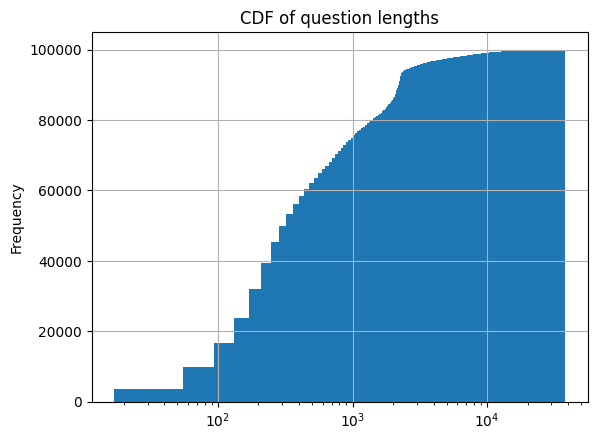

In [4]:
df.qlen.plot.hist(logx=True, bins=1000, cumulative=True, grid=True, title='CDF of question lengths')

<Axes: title={'center': 'CDF of response lengths'}, ylabel='Frequency'>

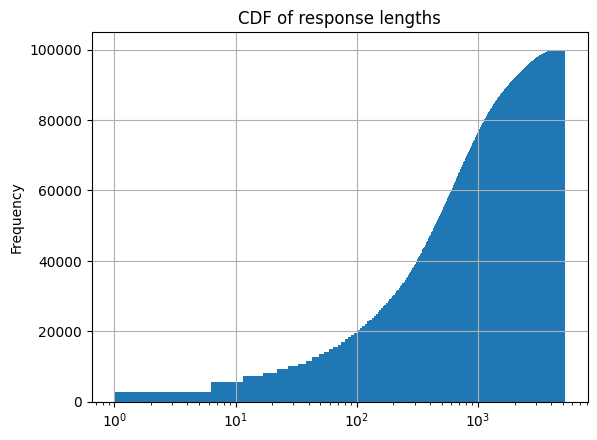

In [5]:
df.rlen.plot.hist(logx=True, bins=1000, cumulative=True, grid=True, title='CDF of response lengths')

In [7]:
import pandas as pd
import numpy as np

TextChunk = ll.splitters.chunk_splitter.TextChunk


In [8]:
def read_chunk_cases(filename):
  raw_df = pd.read_csv(filename)
  chunks_as_list = raw_df[raw_df.columns[2:]].apply(lambda row: list(filter(pd.notna, row)), axis=1)
  processed_df = pd.DataFrame({
    'source': raw_df['source'],
    'text': raw_df['input'],
    'raw_chunks': chunks_as_list,
  })
  text_chunks: list[list[TextChunk]] = []
  for _, text, chunks in processed_df.itertuples(index=False):
    text_spans = []
    for chunk in chunks:
      chunk = chunk.strip()
      assert text.count(
        chunk) == 1, f"Found 0 or 2+ occurrences:\n\nCHUNK:\n{chunk}\n\nTEXT:\n{text}"
      start, end = text.index(chunk), text.index(chunk) + len(chunk)
      text_spans.append((chunk, (start, end)))
    text_chunks.append(text_spans)
  processed_df['text_chunks'] = text_chunks
  return processed_df


In [9]:
chunk_tests = read_chunk_cases('notebooks/unmaintained/chunking_cases.csv')

In [10]:
from lilac.embeddings.transformer_utils import get_model

_, gte_embedder = get_model('thenlper/gte-small', {'': 32, 'mps': 64})

In [11]:
from typing import Sequence, Optional
from scipy.spatial.distance import cdist


def jaccard_overlap(chunk1: TextChunk, chunk2: TextChunk):
  _, (s1, e1) = chunk1
  _, (s2, e2) = chunk2
  intersect = min(e1, e2) - max(s1, s2)
  if intersect < 0:
    return 0
  union = max(e1, e2) - min(s1, s2)
  return intersect / union


def jaccard_chunk_recall(chunk_guess: Sequence[TextChunk], chunk_true: Sequence[TextChunk]):
  all_scores = [[jaccard_overlap(guess, true) for guess in chunk_guess] for true in chunk_true]
  return np.array(all_scores).max(axis=1).mean(axis=0)


def jaccard_chunk_precision(chunk_guess: Sequence[TextChunk], chunk_true: Sequence[TextChunk]):
  all_scores = [[jaccard_overlap(guess, true) for guess in chunk_guess] for true in chunk_true]
  return np.array(all_scores).max(axis=0).mean(axis=0)


def embedder_chunk_recall(chunk_guess: Sequence[TextChunk], chunk_true: Sequence[TextChunk]):
  chunk_scores = []
  # Every "semantic idea" represented in the true chunks should be represented among the
  # emitted chunks in some way.
  true_embeddings = gte_embedder.encode([c[0] for c in chunk_true])
  guess_embeddings = gte_embedder.encode([c[0] for c in chunk_guess])
  cross_similarity = 1 - cdist(true_embeddings, guess_embeddings, metric='cosine')
  return cross_similarity.max(axis=1).mean(axis=0)


def embedder_chunk_precision(chunk_guess: Sequence[TextChunk], chunk_true: Sequence[TextChunk]):
  chunk_scores = []
  # Every "semantic idea" represented in the true chunks should be represented among the
  # emitted chunks in some way.
  true_embeddings = gte_embedder.encode([c[0] for c in chunk_true])
  guess_embeddings = gte_embedder.encode([c[0] for c in chunk_guess])
  cross_similarity = 1 - cdist(true_embeddings, guess_embeddings, metric='cosine')
  return cross_similarity.max(axis=0).mean(axis=0)


def evaluate_chunker(method, debug=False):
  chunk_true = chunk_tests['text_chunks']
  chunk_guess = chunk_tests['text'].map(method)
  jaccard_recall = list(map(jaccard_chunk_recall, chunk_guess, chunk_true))
  jaccard_precision = list(map(jaccard_chunk_precision, chunk_guess, chunk_true))
  embed_recall = list(map(embedder_chunk_recall, chunk_guess, chunk_true))
  embed_precision = list(map(embedder_chunk_precision, chunk_guess, chunk_true))

  if debug:
    import random
    i = random.randrange(len(chunk_true))
    print('Expected:\n', chunk_true[i])
    print('Actual:\n', chunk_guess[i])

  results_df = pd.DataFrame({
    'group': chunk_tests.source,
    'jaccard_recall': jaccard_recall,
    'jaccard_precision': jaccard_precision,
    'embedding_recall': embed_recall,
    'embedding_precision': embed_precision,
    'len_true_chunks': chunk_tests.text_chunks.map(len),
    'len_guess_chunks': chunk_guess.map(len),
  })
  summary_df = results_df.groupby('group').mean()
  summary_df.loc['overall'] = results_df.loc[:, results_df.columns != 'group'].mean(axis=0)

  display(summary_df.round(3))


In [12]:
evaluate_chunker(ll.splitters.split_text)

,jaccard_recall,jaccard_precision,embedding_recall,embedding_precision,len_true_chunks,len_guess_chunks
group,,,,,,
Lilac markdown docs,0.355,0.628,0.940,0.970,7.800,3.000
Lilac python code,0.510,0.742,0.946,0.980,9.667,4.333
"OpenOrca100k Question, random sampling",0.494,0.662,0.926,0.959,3.500,2.200
"OpenOrca100k Response, random sampling",0.781,0.743,0.970,0.975,3.200,3.800
overall,0.552,0.685,0.941,0.966,4.474,2.895


In [13]:
%%time
import spacy
from spacy.lang.en import English
sentencizer = spacy.blank('en')
sentencizer.add_pipe('sentencizer', config={'punct_chars': [':', ';', '.', '!', '?']})
# Increase the number of characters of the tokenizer as we're not using a parser or NER.
sentencizer.max_length = 10_000_000


CPU times: user 416 ms, sys: 91.9 ms, total: 508 ms
Wall time: 646 ms


In [14]:
%%time
def simple_spacy_chunker(text):
  chunks = [(text[s.start_char:s.end_char], (s.start_char, s.end_char)) for s in sentencizer(text).sents]
  # Filter out stray whitespace, list numberings, etc.
  chunks = [c for c in chunks if len(c[0].strip()) > 4]
  return chunks
evaluate_chunker(simple_spacy_chunker)

,jaccard_recall,jaccard_precision,embedding_recall,embedding_precision,len_true_chunks,len_guess_chunks
group,,,,,,
Lilac markdown docs,0.646,0.583,0.971,0.953,7.800,10.600
Lilac python code,0.494,0.364,0.950,0.913,9.667,16.000
"OpenOrca100k Question, random sampling",0.709,0.558,0.965,0.939,3.500,7.450
"OpenOrca100k Response, random sampling",0.673,0.557,0.969,0.948,3.200,7.100
overall,0.674,0.546,0.966,0.941,4.474,8.447


CPU times: user 6.19 s, sys: 1.11 s, total: 7.3 s
Wall time: 7.53 s


In [15]:
%%time
def greedy_grouping_spacy_chunker(text, max_len=512):
  simple_chunks = simple_spacy_chunker(text)

  def ensure_len(chunks):
    for chunk in chunks:
      if len(chunk[0]) < max_len:
        yield chunk
      else:
        chunk_text, (start, end) = chunk
        yield chunk_text[:max_len], (start, start + max_len)

  def fuse_chunks(chunks):
    return ''.join(c[0] for c in chunks), (chunks[0][1][0], chunks[-1][1][1])

  grouped_chunks = []
  cur_len = 0
  cur_chunks = []
  for chunk in ensure_len(simple_chunks):
    chunk_text, (chunk_start, chunk_end) = chunk
    if cur_len + chunk_end - chunk_start > max_len:
      grouped_chunks.append(fuse_chunks(cur_chunks))
      cur_chunks = []
      cur_len = 0
    cur_chunks.append(chunk)
    cur_len += len(chunk_text)
  if cur_chunks:
    grouped_chunks.append(fuse_chunks(cur_chunks))
  return grouped_chunks


evaluate_chunker(greedy_grouping_spacy_chunker)

,jaccard_recall,jaccard_precision,embedding_recall,embedding_precision,len_true_chunks,len_guess_chunks
group,,,,,,
Lilac markdown docs,0.260,0.541,0.925,0.969,7.800,2.200
Lilac python code,0.296,0.573,0.916,0.951,9.667,2.333
"OpenOrca100k Question, random sampling",0.433,0.646,0.915,0.959,3.500,1.600
"OpenOrca100k Response, random sampling",0.629,0.735,0.952,0.979,3.200,2.400
overall,0.451,0.650,0.926,0.965,4.474,1.947


CPU times: user 6.03 s, sys: 1.03 s, total: 7.06 s
Wall time: 7.12 s


In [16]:
import bisect
from typing import Optional


def group_by_embedding(fulltext: str, chunks: list[TextChunk], min_groups,
                       max_len) -> list[TextChunk]:
  embeddings = gte_embedder.encode([c[0] for c in chunks])
  embeddings -= embeddings.mean(axis=0)
  neighbor_distances: Sequence[float] = (embeddings[:-1] * embeddings[1:]).sum(axis=1)

  potential_breaks: Sequence[int] = np.array([c[1][1] for c in chunks[:-1]
                                             ])  # end index of each chunk
  priority_sort_breaks: Sequence[int] = potential_breaks[np.argsort(neighbor_distances)]

  breakpoints = [0] + sorted(priority_sort_breaks[:min_groups]) + [chunks[-1][1][1]]

  def find_long_spans(breakpoints) -> Optional[tuple[int, int]]:
    for i, j in zip(breakpoints[:-1], breakpoints[1:]):
      if j - i > max_len:
        return (i, j)
    return None

  while (span := find_long_spans(breakpoints)) is not None:
    i, j = span
    for potential_break in priority_sort_breaks:
      if i < potential_break < j:
        bisect.insort(breakpoints, potential_break)
        break
    else:  # No potential breaker was found. Arbitrarily split the span in half.
      bisect.insort(breakpoints, int((i + j) / 2))

  return [
    (fulltext[start:end], (start, end)) for start, end in zip(breakpoints[:-1], breakpoints[1:])
  ]


def clustering_spacy_chunker(text, max_len=512):
  chunks = simple_spacy_chunker(text)
  min_groups = int(
    (len(text)**0.33) / 1.5)  ## 1/3 power is eyeballed from texts spanning 50-5000 in len.
  return group_by_embedding(text, chunks, min_groups, max_len)


In [17]:
evaluate_chunker(clustering_spacy_chunker)

,jaccard_recall,jaccard_precision,embedding_recall,embedding_precision,len_true_chunks,len_guess_chunks
group,,,,,,
Lilac markdown docs,0.519,0.602,0.959,0.959,7.800,6.200
Lilac python code,0.507,0.522,0.945,0.936,9.667,7.667
"OpenOrca100k Question, random sampling",0.748,0.643,0.967,0.948,3.500,4.800
"OpenOrca100k Response, random sampling",0.712,0.603,0.974,0.956,3.200,5.200
overall,0.689,0.618,0.966,0.951,4.474,5.316


In [18]:
i = 0

In [19]:
chunker_outputs = [
  ('GROUND TRUTH ', chunk_tests.iloc[i].text_chunks),
  ('CURRENT CHUNKER', ll.splitters.split_text(chunk_tests.iloc[i].text)),
  ('SPACY SENTENCE CHUNKER', simple_spacy_chunker(chunk_tests.iloc[i].text)),
  #  ('SPACY SENTENCE-GREEDY CHUNKER', greedy_grouping_spacy_chunker(chunk_tests.iloc[i].text)),
  ('SPACY EMBEDDING-GROUP CHUNKER', clustering_spacy_chunker(chunk_tests.iloc[i].text)),
]
for chunker_name, chunk_attempts in chunker_outputs:
  print(chunker_name,
        jaccard_chunk_recall(chunk_attempts, chunk_tests.iloc[i].text_chunks).round(3),
        jaccard_chunk_precision(chunk_attempts, chunk_tests.iloc[i].text_chunks).round(3),
        embedder_chunk_recall(chunk_attempts, chunk_tests.iloc[i].text_chunks).round(3),
        embedder_chunk_precision(chunk_attempts, chunk_tests.iloc[i].text_chunks).round(3))
  for chunk, span in chunk_attempts:
    print(span, '\n', chunk)
  print('\n\n')
i += 1


GROUND TRUTH  1.0 1.0 1.0 1.0
(0, 94) 
 Select from the following.
 (1). Yes
 (2). No
Given those answer options, answer the question:
(95, 121) 
 Title: Fast download to PC
(122, 263) 
 Review: This reader really shines with a fast card. I was able to transfer files from a full 1GB card (Lexar 80X) in 1 minute and 43 seconds.
(263, 486) 
 The only issue I have with the reader is that it gets warm, much warmer than my older Sandisk USB reader. Even with no card attached, it's warm. I've made it a routine to remove the card as soon as the download is finished.
(487, 522) 
 Is this product review negative?
A:



CURRENT CHUNKER 0.313 0.324 0.921 0.91
(0, 45) 
 Select from the following.
 (1). Yes
 (2). No
(46, 444) 
 Given those answer options, answer the question: Title: Fast download to PC Review: This reader really shines with a fast card. I was able to transfer files from a full 1GB card (Lexar 80X) in 1 minute and 43 seconds.The only issue I have with the reader is that it gets warm